##### 01_multiKDE_bootstrap.ipynb

### Author: Lewis Kunik - University of Utah
### Contact: lewiskunik@gmail.com

##### <u>Description:</u>
This notebook demonstrates how to perform the multiKDE bootstrap method described in the paper:
Kunik et al. (2025) Can we detect forest mortality using satellite observations of solar-induced chlorophyll fluorescence?


First load necessary packages and functions:

In [ ]:

#########################################
# Load packages
#########################################

#%%
# File system packages
import os  # operating system library
import sys

# Load the custom modules included in the 'include' directory
sys.path.append('include')
import pixel_classes
import bootstrap_functions as functions
import bootstrap_map_functions as map_functions

# runtime packages
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# Suppress UserWarning about centroid in geographic CRS globally
warnings.filterwarnings("ignore", message="Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect.*")

# numerical/data management packages
import numpy as np
import xarray as xr  # for multi dimensional data
import pandas as pd

# shapefile/geospatial packages
import geopandas as gpd
from shapely.geometry import mapping

# plotting packages
from matplotlib import pyplot as plt  # primary plotting module
from IPython import display

#NOTE that other necessary packages are loaded in the bootstrap_functions.py and bootstrap_map_functions.py files


Now define global filepaths and variables:

In [2]:
#########################################
# Define Global Filepaths
#########################################

# directories
dat_dir = 'data/'
# dat_dir = '/uufs/chpc.utah.edu/common/home/lin-group19/ltk/bootstrap/code/for_github/data'

# path to processed TROPOMI SIF file
SIF_file = os.path.join(dat_dir, 'TROPOMI_SIF740nm_05deg_16d_sample.nc')

# path to processed NASA elev DEM file
elev_file = os.path.join(dat_dir, 'SRTM_DEM_05d_WUS.nc')

# path to processed NLCD Tree Canopy Cover file, snapshot of year 2021
TCC_file = os.path.join(dat_dir, 'NLCD_TCC_05d_WUS_2021.nc')

########################################
# Define Global Variables and constants
#########################################

### Variables specific to the dataset 
dat_var = 'sifdc' # this is the name of the variable to be accessed in the dataset
var_units = 'mW/m2/sr/nm'

# Number of bootstrapping iterations to loop through
num_repeats = 100 # normally you would want to use a larger number (e.g. 500). We use 100 to make the example run faster
plot_pixel_maps = True

mortality_detection_year = 2023
include_months_lab = 'Aug-Oct'
include_months_descr = 'late_summer'
discard_months = [11, 12, 1, 2, 3, 4, 5, 6, 7] # define months to discard (months when snowcover may affect signal or when understory may impose strong bias)

control_sample_size = 100 # Number of control pixels to sample for each bootstrap iteration

# Calculate the estimated mortality year as 1 year before the detection year
estimated_mortality_year = mortality_detection_year - 1

### Filepaths to mortality/control shapefiles:
control_polygon_filepath = os.path.join(dat_dir,'shp/control_pixels_05d.shp') # For Bark Beetle Mortality
mortality_polygon_filepath =  os.path.join(dat_dir, 'shp/mortality_pixels_2023_ModerateSevere_MA_25-35p_05d.shp') # For Bark Beetle Mortality
wildfire_studyarea_polygon_filepath = os.path.join(dat_dir, 'shp/EPA_L3_ecoregion_studyarea_wildfire.shp') # For Wildfire Mortality
barkbeetle_studyarea_polygon_filepath = os.path.join(dat_dir, 'shp/EPA_L3_ecoregion_studyarea_beetle.shp') # For Bark Beetle Mortality

# Define parameters for Kernel Density Estimation of land surface characteristic distributions
elevation_bin = 100 # meters
elevation_range = np.linspace(0, 4000, 1000)#[:, None]  #uncomment the [:, None] if using 1D KDE
LAI_bin = 0.25 # unitless
LAI_range = np.linspace(0, 8, 1000)#[:, None] #uncomment the [:, None] if using 1D KDE
TCC_bin = 5 # percent
TCC_range = np.linspace(0, 100, 1000)#[:, None] #uncomment the [:, None] if using 1D KDE

# select for only these years when working with data files
analysis_years = np.array(range(2015, 2024))

# Colors for plotting
mortality_color = "#aa021e" # Line/point color for plots
control_color = "#0219aa"



For simplicity, functions are stored in the bootstrap_functions.py and bootstrap_map_functions.py files in the include directory

In [3]:
#########################################
# Define Global Functions
#########################################


# See "include/bootstrap_functions.py" and "include/bootstrap_map_functions.py" for the functions used in this script


Start by loading the mortality and control pixels, which are stored as ESRI shapefiles and represented as multipolygon geometries. 

Each polygon defining a pixel includes the longitude and latitude bounds of that grid cell within the raster datasets, plus a very small (0.00005°) buffer on the outside to ensure that the rioxarray clip function will always include the correct data when clipped

This code chunk plots a map of all eligible mortality and control pixels within the bark beetle bootstrap domain

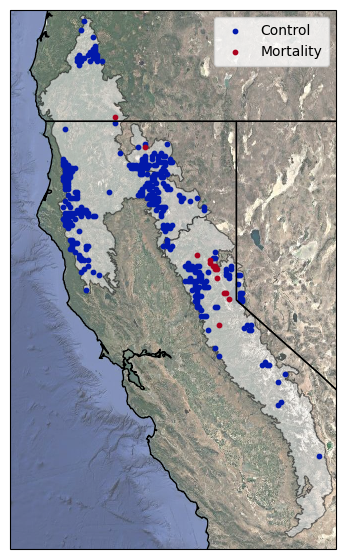

In [4]:
#########################################
# Begin Main
#########################################

### Load geopandas shapefile data for mortality and control pixel superset

# all mortality pixels 
mortality_polygon_gdf = gpd.read_file(mortality_polygon_filepath)
mortality_polygon_geom = mortality_polygon_gdf.geometry.apply(mapping)
num_mortality_pixels = len(mortality_polygon_gdf)

# all control pixels
control_polygon_gdf = gpd.read_file(control_polygon_filepath)
control_polygon_geom = control_polygon_gdf.geometry.apply(mapping)
num_control_pixels = len(control_polygon_geom)

# Plot map of the control and mortality pixels
control_centroids = control_polygon_gdf.centroid
mortality_centroids = mortality_polygon_gdf.centroid
map_functions.plot_mortality_control_pixel_map(control_centroids, mortality_centroids)


In [5]:

#########################################
# Load DEM, Tree Canopy Cover and satellite RS datasets
#########################################

# Load NASA SRTM elevation (pre-gridded to 0.05°)
print('Loading elevation dataset')
elev_xr = xr.open_dataset(elev_file).squeeze('band').rename({'lon':'x', 'lat':'y'}).sortby(['x', 'y'])
elev_xr.rio.write_crs(4326, inplace = True) # specify WGS84 as CRS

# Load NLCD Tree Canopy Cover (pre-gridded to 0.05°)
TCC_xr = xr.open_dataset(TCC_file).squeeze('band').rename({'lon':'x', 'lat':'y'}).sortby(['x', 'y']) # Assume grid matches with elevation dataset (already checked)
TCC_xr.rio.write_crs(4326, inplace = True) # specify WGS84 as CRS

# Load TROPOMI SIF 0.05° gridded dataset
SIF_xr = xr.open_dataset(SIF_file, decode_coords='all').sortby(['lon', 'lat'])
SIF_xr = SIF_xr.sel(time=SIF_xr['time.year'].isin(analysis_years))
SIF_xr.rio.write_crs(4326, inplace=True)



Loading elevation dataset


<xarray.Dataset> Size: 20MB
Dimensions:      (lat: 160, lon: 120, time: 130)
Coordinates:
  * lat          (lat) float32 640B 36.03 36.08 36.12 ... 43.88 43.92 43.97
  * lon          (lon) float32 480B -124.0 -123.9 -123.9 ... -118.1 -118.0
  * time         (time) datetime64[ns] 1kB 2018-05-01 2018-05-17 ... 2023-12-25
    spatial_ref  int64 8B 0
Data variables:
    sifdc        (lat, lon, time) float32 10MB ...
    sifdc_std    (lat, lon, time) float32 10MB ...
Attributes:
    title:    Awesome gridded file

Now we compute the Kernel Density Estimation (KDE) of elevation and tree canopy cover (TCC) from the NASA SRTM and NLCD datasets, respectively. The KDE represents the smoothed distribution from the histogram of the elevation and TCC data. Density functions (which are the distributions normalized to 1) are also computed.

In [6]:
##################################################################################
# calculate the distributions of elevation and tree canopy cover across the mortality pixels
##################################################################################
   
elev_mortality_kde, elev_mortality_density, elev_mortality_non_nan = functions.compute_kde_density_from_gdf(mortality_polygon_gdf, elev_xr, 'elevation', elevation_range)
elev_control_kde, elev_control_density, elev_control_non_nan = functions.compute_kde_density_from_gdf(control_polygon_gdf, elev_xr, 'elevation', elevation_range)
TCC_mortality_kde, TCC_mortality_density, TCC_mortality_non_nan = functions.compute_kde_density_from_gdf(mortality_polygon_gdf, TCC_xr, 'tree_canopy_cover', TCC_range)
TCC_control_kde, TCC_control_density, TCC_control_non_nan = functions.compute_kde_density_from_gdf(control_polygon_gdf, TCC_xr, 'tree_canopy_cover', TCC_range)

# get mean for later scaling
elev_control_mean = np.mean(elev_control_non_nan)
TCC_control_mean = np.mean(TCC_control_non_nan)

# clip the elevation and TCC datasets to the control polygons
elev_xr_control_clip = elev_xr.rio.clip(control_polygon_geom, crs=4326)
TCC_xr_control_clip = TCC_xr.rio.clip(control_polygon_geom, crs=4326)

# Flatten the control datasets for use in the bootstrap step
elev_control_flat = elev_xr_control_clip.elevation.data.flatten()
TCC_control_flat = TCC_xr_control_clip.tree_canopy_cover.data.flatten()

Let's plot the histograms and the KDEs of the elevation data for the mortality pixel set, as well as for the control pixel set.

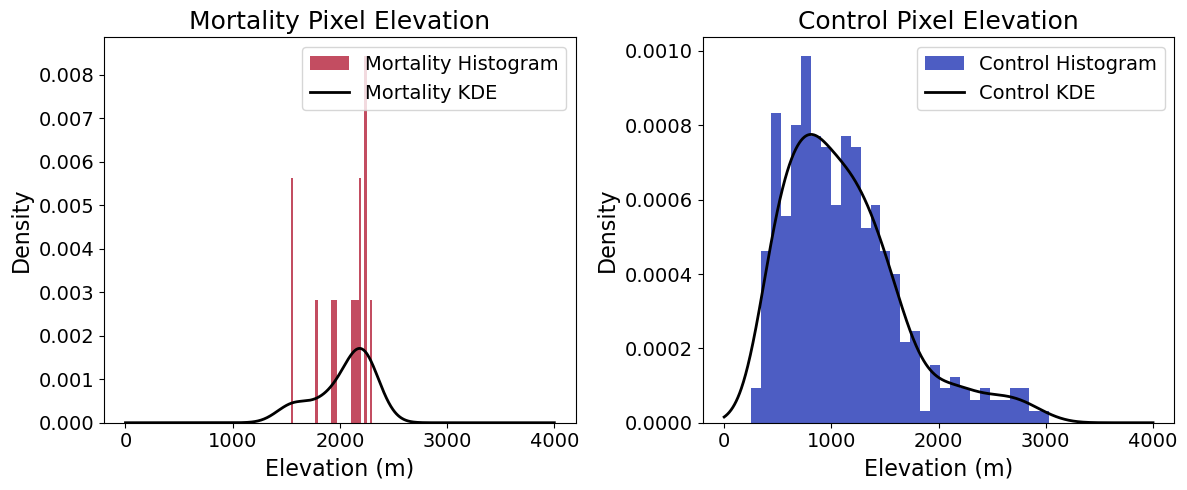

In [7]:

# Set global matplotlib font sizes for axes and legends
plt.rcParams.update({
   'axes.labelsize': 16,
   'axes.titlesize': 18,
   'xtick.labelsize': 14,
   'ytick.labelsize': 14,
   'legend.fontsize': 14
})
# Plot histograms of elev_mortality_non_nan and elev_control_non_nan with KDE overlays
plt.figure(figsize=(12, 5))

# Elevation histogram + KDE for Mortality
plt.subplot(1, 2, 1)
plt.hist(elev_mortality_non_nan, bins=30, color=mortality_color, alpha=0.7, density=True, label='Mortality Histogram')
plt.plot(elevation_range, elev_mortality_density, color='black', linewidth=2, label='Mortality KDE')
plt.xlabel('Elevation (m)')
plt.ylabel('Density')
plt.title('Mortality Pixel Elevation')
plt.legend()

# Elevation histogram + KDE for Control
plt.subplot(1, 2, 2)
plt.hist(elev_control_non_nan, bins=30, color=control_color, alpha=0.7, density=True, label='Control Histogram')
plt.plot(elevation_range, elev_control_density, color='black', linewidth=2, label='Control KDE')
plt.xlabel('Elevation (m)')
plt.ylabel('Density')
plt.title('Control Pixel Elevation')
plt.legend()

plt.tight_layout()
plt.show()

Let's do the same, but for tree canopy cover (TCC) data

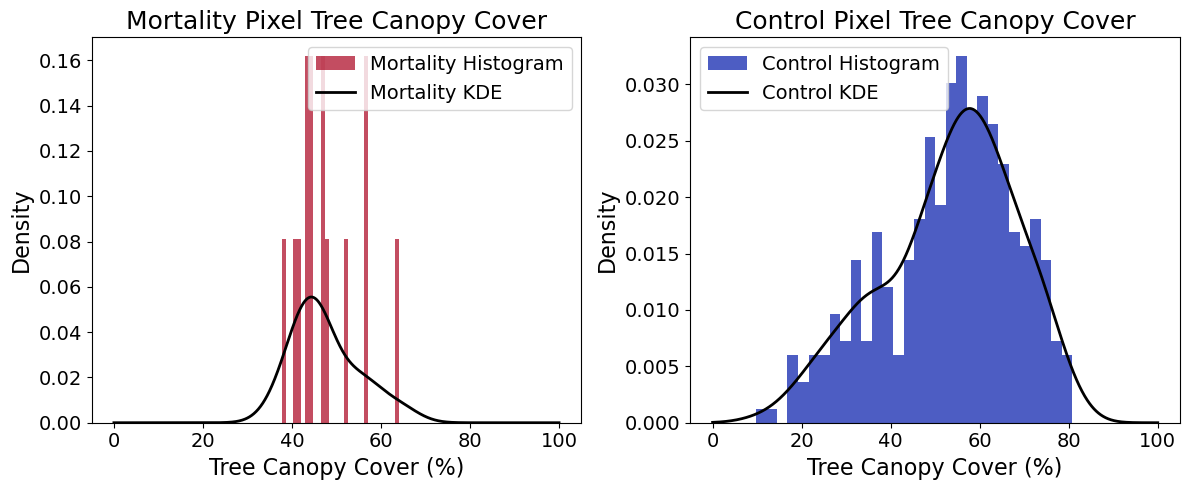

In [8]:
# Plot histograms of TCC_mortality_non_nan and TCC_control_non_nan with KDE overlays
plt.figure(figsize=(12, 5))

# Tree Canopy Cover histogram + KDE for Mortality
plt.subplot(1, 2, 1)
plt.hist(TCC_mortality_non_nan, bins=30, color=mortality_color, alpha=0.7, density=True, label='Mortality Histogram')
plt.plot(TCC_range, TCC_mortality_density, color='black', linewidth=2, label='Mortality KDE')
plt.xlabel('Tree Canopy Cover (%)')
plt.ylabel('Density')
plt.title('Mortality Pixel Tree Canopy Cover')
plt.legend()

# Tree Canopy Cover histogram + KDE for Control
plt.subplot(1, 2, 2)
plt.hist(TCC_control_non_nan, bins=30, color=control_color, alpha=0.7, density=True, label='Control Histogram')
plt.plot(TCC_range, TCC_control_density, color='black', linewidth=2, label='Control KDE')
plt.xlabel('Tree Canopy Cover (%)')
plt.ylabel('Density')
plt.title('Control Pixel Tree Canopy Cover')
plt.legend()

plt.tight_layout()
plt.show()


### Bootstrap implementation

Now let's demonstrate how the bootstrap works. First, we will iterate through the resampling procedure and display a map of the sampled mortality and control pixels, along with the KDEs of the elevation and TCC data for each iteration. 

Note that the resampling approach is specifically designed to minimize the distance in elevation and TCC between the mortality dataset and the control-resampled dataset. So for each iteration, a new set of control pixels are selected which should roughly match the elevation and TCC distributions of the mortality pixels.

When executing this code block, the map and KDEs will update with each iteration - when viewing statically, it just shows the final iteration of the bootstrap.

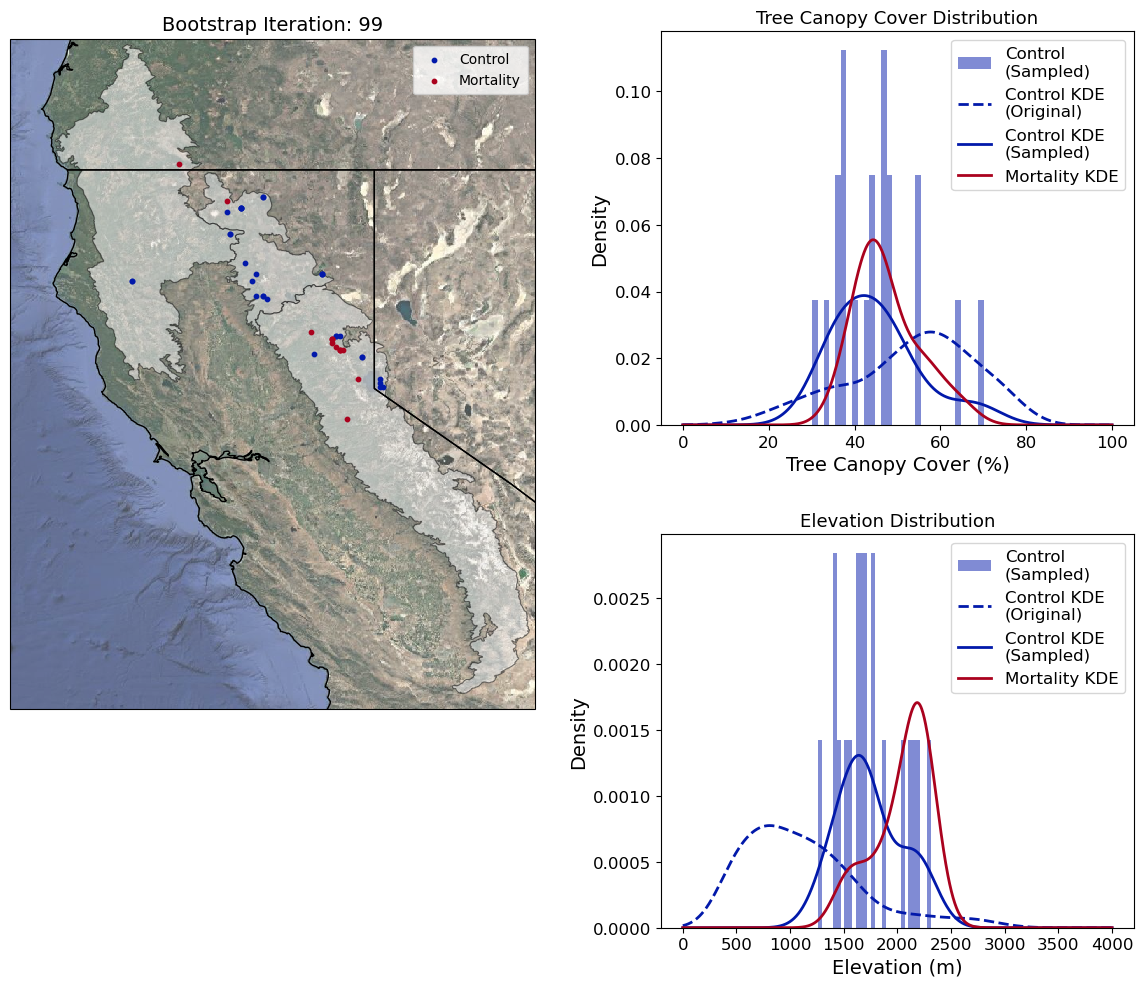

In [9]:
    
# Set global matplotlib font sizes for axes and legends
plt.rcParams.update({
   'axes.labelsize': 14,
   'axes.titlesize': 13,
   'xtick.labelsize': 12,
   'ytick.labelsize': 12,
   'legend.fontsize': 12
})

if plot_pixel_maps:

   for ensemble_iter in range(num_repeats):

      # print(f'Bootstrap iteration: {ensemble_iter:02d}')

      #########################################
      # Establish Mortality datastructure
      #########################################

      # Randomly sample rows of the mortality_polygon_gdf object
      mortality_centroids = []
      mortality_polygon_gdf_sampled = mortality_polygon_gdf.sample(num_mortality_pixels, replace=True)

      # Populate Mortality sample with pixels
      for pixel_center in mortality_polygon_gdf_sampled.centroid:
         mortality_centroids.append(gpd.points_from_xy([pixel_center.x], [pixel_center.y])[0])
      mortality_centroids = gpd.GeoSeries(mortality_centroids)


      #########################################
      # Establish Control datastructure
      #########################################

      # Sample new values based on the densities
      sampled_elev_values = elev_mortality_kde.resample(control_sample_size).flatten()
      sampled_TCC_values = TCC_mortality_kde.resample(control_sample_size).flatten()

      # Find indices in the control domain where both elevation and LAI match closely
      matching_indices = []
      control_polygon_gdf_KDE_FILTER = gpd.GeoDataFrame(columns=control_polygon_gdf.columns, crs=control_polygon_gdf.crs)

      for elev_val, TCC_val in zip(sampled_elev_values, sampled_TCC_values):
         # Calculate the normalized differences of each var
         elev_diffs = np.abs(elev_control_flat - elev_val)/elev_control_mean # divide by mean to normalize
         TCC_diffs = np.abs(TCC_control_flat - TCC_val)/TCC_control_mean # divide by mean to normalize
         
         # Combine constraints: find indices where combined differences are minimal
         overall_diffs = elev_diffs + TCC_diffs
         matching_idx = np.nanargmin(overall_diffs) # identify the index of the minimum difference
         
         # Append the index if not already present (retains only unique pixels)
         if matching_idx not in matching_indices:
            matching_indices.append(matching_idx)

      # Convert the original indices to unique x/y coordinates
      sampled_coords = np.unravel_index(matching_indices, elev_xr_control_clip.elevation.shape)

      # Extract x and y coordinates as indices from the original datasets' grid
      sampled_x_icoords = sampled_coords[1]
      sampled_y_icoords = sampled_coords[0]

      # Loop through the sampled coordinates and recreate the gridded points where elevations were selected
      for ii in range(len(sampled_x_icoords)):
         x_coord = elev_xr_control_clip.x.values[sampled_x_icoords[ii]]
         y_coord = elev_xr_control_clip.y.values[sampled_y_icoords[ii]]

         # Find the closest point in control_polygon_gdf for each x, y coordinate pair
         distances = control_polygon_gdf.geometry.apply(lambda geom: geom.distance(gpd.points_from_xy([x_coord], [y_coord])[0]))
         closest_point_index = distances.idxmin()
         closest_point = control_polygon_gdf.loc[closest_point_index]
         
         # Filter control_polygon_gdf for points that are matched to these sets of coordinates
         control_polygon_gdf_KDE_FILTER = pd.concat([control_polygon_gdf_KDE_FILTER, closest_point.to_frame().T])

      # control_polygon_gdf_KDE_FILTER is now just like control_polygon_gdf but with a similar elevation distrib to mortality pixels
      num_control_pixels = len(control_polygon_gdf_KDE_FILTER)

      # Randomly sample rows of the mortality_polygon_gdf object
      control_polygon_gdf_sampled = control_polygon_gdf_KDE_FILTER.sample(num_control_pixels, replace=True)

      elev_control_kde_sampled, elev_control_density_sampled, elev_control_non_nan_sampled = functions.compute_kde_density_from_gdf(control_polygon_gdf_sampled, elev_xr, 'elevation', elevation_range)
      TCC_control_kde_sampled, TCC_control_density_sampled, TCC_control_non_nan_sampled = functions.compute_kde_density_from_gdf(control_polygon_gdf_sampled, TCC_xr, 'tree_canopy_cover', TCC_range)

      # Populate Control sample with pixels
      control_centroids = []
      for pixel_center in control_polygon_gdf_sampled.centroid:
         control_centroids.append(gpd.points_from_xy([pixel_center.x], [pixel_center.y])[0])
      control_centroids = gpd.GeoSeries(control_centroids)



      # Clear the previous output
      display.clear_output(wait=True)
      plt.figure(figsize=(12, 10))
      ax_map = plt.subplot2grid((2, 2), (0, 0), rowspan=2, projection=ccrs.PlateCarree())
      ax_tcc_kde = plt.subplot2grid((2, 2), (0, 1))
      ax_elev_kde = plt.subplot2grid((2, 2), (1, 1))


      # Adjust subplot positions to add buffer/margins
      plt.subplots_adjust(left=0.03, right=0.97, top=0.96, bottom=0.02, wspace=0.15, hspace=0.15)
      box_tcc = ax_tcc_kde.get_position()
      box_elev = ax_elev_kde.get_position()
      # Shrink and move the TCC plot
      ax_tcc_kde.set_position([box_tcc.x0 + 0.04, box_tcc.y0 + 0.04, box_tcc.width * 0.9, box_tcc.height * 0.9])
      # Shrink and move the Elevation plot
      ax_elev_kde.set_position([box_elev.x0 + 0.04, box_elev.y0 + 0.04, box_elev.width * 0.9, box_elev.height * 0.9])
      # Move ax_map to align its top with the top of the figure, keeping its horizontal position
      box_map = ax_map.get_position()
      new_height = box_map.height + (1.0 - box_map.y1)
      ax_map.set_position([box_map.x0, 1.0 - new_height, box_map.width, new_height])

      # TCC comparison plot (top right)
      ax_tcc_kde.hist(TCC_control_non_nan_sampled, bins=30, color=control_color, alpha=0.5, 
                  density=True, label='Control\n(Sampled)')
      ax_tcc_kde.plot(TCC_range, TCC_control_density, color=control_color,
                  linewidth=2, linestyle='--', label='Control KDE\n(Original)')
      ax_tcc_kde.plot(TCC_range, TCC_control_density_sampled, color=control_color, 
                  linewidth=2, label='Control KDE\n(Sampled)')
      ax_tcc_kde.plot(TCC_range, TCC_mortality_density, color=mortality_color, 
                  linewidth=2, label='Mortality KDE')
      
      ax_tcc_kde.set_xlabel('Tree Canopy Cover (%)')
      ax_tcc_kde.set_ylabel('Density')
      ax_tcc_kde.set_title('Tree Canopy Cover Distribution')
      ax_tcc_kde.legend()

      # Elevation comparison plot (bottom right)
      ax_elev_kde.hist(elev_control_non_nan_sampled, bins=30, color=control_color, alpha=0.5, 
                  density=True, label='Control\n(Sampled)')
      ax_elev_kde.plot(elevation_range, elev_control_density, color=control_color, 
                  linewidth=2, linestyle='--', label='Control KDE\n(Original)')
      ax_elev_kde.plot(elevation_range, elev_control_density_sampled, color=control_color, 
                  linewidth=2, label='Control KDE\n(Sampled)')
      ax_elev_kde.plot(elevation_range, elev_mortality_density, color=mortality_color, 
                  linewidth=2, label='Mortality KDE')


      ax_elev_kde.set_xlabel('Elevation (m)')
      ax_elev_kde.set_ylabel('Density')
      ax_elev_kde.set_title('Elevation Distribution')
      ax_elev_kde.legend()

      map_functions.plot_mortality_control_pixel_map(control_centroids, mortality_centroids, plotTitle=f'Bootstrap Iteration: {ensemble_iter:02d}', fig=plt.gcf(), ax=ax_map)

      # plt.tight_layout()
      display.display(plt.gcf())
      # time.sleep(0.1)
      plt.close()
      


Now we re-iterate through the resampling procedure to perform the actual calculations of mortality-control comparisons. 

Importantly, we now add the TROPOMI SIF data to each of the pixels using the custom pixel_group class (see include/pixel_classes.py) and filter for only the months of interest (in this case - August, September, and October) and aggregate annually.

This code block plots a four-panel figure (details below)

Top left: For the given loop iteration, this is a comparison of the mean (+/- standard deviation) late-summer TROPOMI SIF for mortality (in red) vs control (in blue) from 2018-2023. The gray shaded region represents the estimated year that mortality onset occurred.

Top right: For the given loop iteration, this is a comparison of the mean (+/- standard deviation) 1-yr change in late-summer TROPOMI SIF (1-yr ΔSIF), with the same color scheme as top-left. The year 2022 is denoted with a dashed white box because the bottom panels represent the cumulative statistics for 1-yr ΔSIF in 2022.

Bottom left: Shows the running-mean difference between mortality and control vs number of cumulative bootstrap iterations. The shaded regions represent the 95% confidence intervals (because they are quantiles, they have less variation with increasing iterations compared to the mean). Note that this quantity is the DIFFERENCE in 1-yr ΔSIF BETWEEN mortality and control, so positive values mean that the 1-yr ΔSIF was higher for mortality pixels than control pixels, and negative values mean that the 1-yr ΔSIF was lowwer for mortality pixels than for control pixels.

Bottom right: shows the running mean p-value from the Mann-Whitney test vs number of cumulative bootstrap iterations, comparing the mortality and control 1-yr ΔSIF values. p values of 0.05 and 0.01 are shown for reference. 

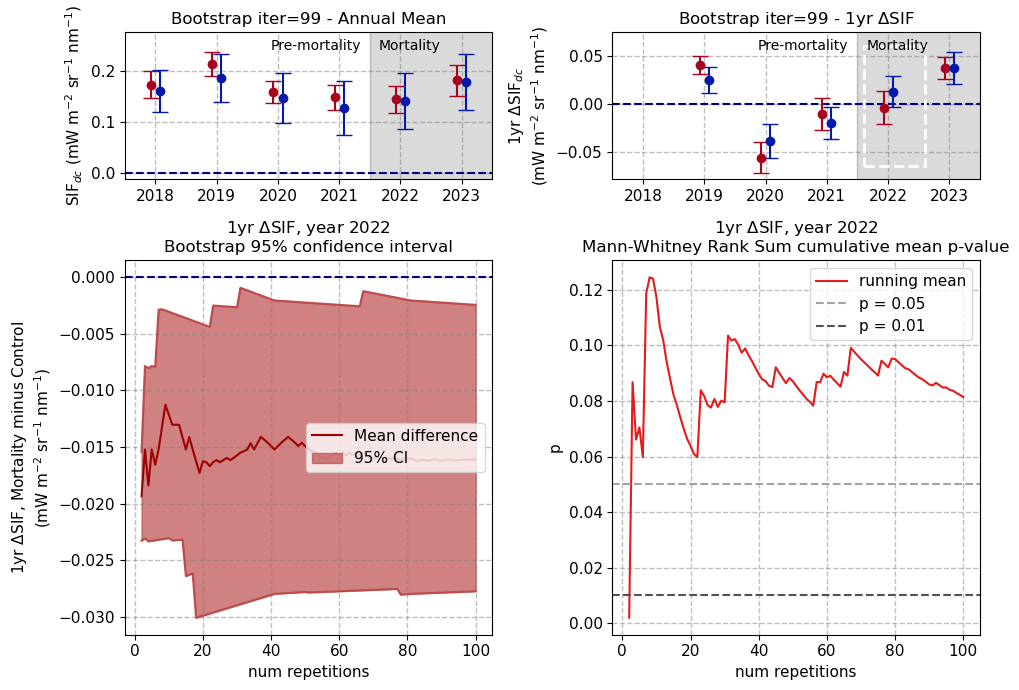

In [10]:
#########################################
# Begin Bootstrapping
#########################################

summary_ann_mean_arr = []
cumulative_summary_ann_mean_arr = []
summary_1yr_delta_arr = []
cumulative_summary_1yr_delta_arr = []

# Set global matplotlib font sizes for axes and legends
plt.rcParams.update({
   'axes.labelsize': 11,
   'axes.titlesize': 12,
   'xtick.labelsize': 11,
   'ytick.labelsize': 11,
   'legend.fontsize': 11
})


for ensemble_iter in range(num_repeats):

   print(f'Bootstrap iteration: {ensemble_iter:02d}')

   #########################################
   # Establish Mortality datastructure
   #########################################

   # Randomly sample rows of the mortality_polygon_gdf object
   mortality_polygon_gdf_sampled = mortality_polygon_gdf.sample(num_mortality_pixels, replace=True)

   # set up disturbed PixelGroup
   mortality_sample = pixel_classes.PixelGroup()

   # Populate Mortality sample with pixels
   for pixel_center in mortality_polygon_gdf_sampled.centroid:
      pixel = pixel_classes.Pixel(center_lon = pixel_center.x,
                                    center_lat = pixel_center.y,
                                    deg_res = 0.05)
      mortality_sample.add_pixel(pixel)

   #########################################
   # Establish Control datastructure
   #########################################

   # Sample new values based on the densities
   sampled_elev_values = elev_mortality_kde.resample(control_sample_size).flatten()
   sampled_TCC_values = TCC_mortality_kde.resample(control_sample_size).flatten()

   # Find indices in the control domain where both elevation and LAI match closely
   matching_indices = []
   control_polygon_gdf_KDE_FILTER = gpd.GeoDataFrame(columns=control_polygon_gdf.columns, crs=control_polygon_gdf.crs)

   for elev_val, TCC_val in zip(sampled_elev_values, sampled_TCC_values):
      # Calculate the normalized differences of each var
      elev_diffs = np.abs(elev_control_flat - elev_val)/elev_control_mean # divide by mean to normalize
      TCC_diffs = np.abs(TCC_control_flat - TCC_val)/TCC_control_mean # divide by mean to normalize
      
      # Combine constraints: find indices where combined differences are minimal
      overall_diffs = elev_diffs + TCC_diffs
      matching_idx = np.nanargmin(overall_diffs) # identify the index of the minimum difference
      
      # Append the index if not already present (retains only unique pixels)
      if matching_idx not in matching_indices:
         matching_indices.append(matching_idx)

   # Convert the original indices to unique x/y coordinates
   sampled_coords = np.unravel_index(matching_indices, elev_xr_control_clip.elevation.shape)

   # Extract x and y coordinates as indices from the original datasets' grid
   sampled_x_icoords = sampled_coords[1]
   sampled_y_icoords = sampled_coords[0]

   # Loop through the sampled coordinates and recreate the gridded points where elevations were selected
   for ii in range(len(sampled_x_icoords)):
      x_coord = elev_xr_control_clip.x.values[sampled_x_icoords[ii]]
      y_coord = elev_xr_control_clip.y.values[sampled_y_icoords[ii]]

      # Find the closest point in control_polygon_gdf for each x, y coordinate pair
      distances = control_polygon_gdf.geometry.apply(lambda geom: geom.distance(gpd.points_from_xy([x_coord], [y_coord])[0]))
      closest_point_index = distances.idxmin()
      closest_point = control_polygon_gdf.loc[closest_point_index]
      
      # Filter control_polygon_gdf for points that are matched to these sets of coordinates
      control_polygon_gdf_KDE_FILTER = pd.concat([control_polygon_gdf_KDE_FILTER, closest_point.to_frame().T])

   # control_polygon_gdf_KDE_FILTER is now just like control_polygon_gdf but with a similar elevation distrib to mortality pixels
   num_control_pixels = len(control_polygon_gdf_KDE_FILTER)

   # Randomly sample rows of the mortality_polygon_gdf object
   control_polygon_gdf_sampled = control_polygon_gdf_KDE_FILTER.sample(num_control_pixels, replace=True)

   elev_control_kde_sampled, elev_control_density_sampled, elev_control_non_nan_sampled = functions.compute_kde_density_from_gdf(control_polygon_gdf_sampled, elev_xr, 'elevation', elevation_range)
   TCC_control_kde_sampled, TCC_control_density_sampled, TCC_control_non_nan_sampled = functions.compute_kde_density_from_gdf(control_polygon_gdf_sampled, TCC_xr, 'tree_canopy_cover', TCC_range)


   # set up Pixel Group for control
   control_sample = pixel_classes.PixelGroup()

   # Populate Control sample with pixels
   for pixel_center in control_polygon_gdf_sampled.centroid:
      pixel = pixel_classes.Pixel(center_lon = pixel_center.x,
                                    center_lat = pixel_center.y,
                                    deg_res = 0.05)
      control_sample.add_pixel(pixel)


   #######################################################
   # Add data to the Mortality and Control pixel group datastructures
   #######################################################

   mortality_sample.add_xr_to_all_pixels(xr_da = SIF_xr[dat_var], var_name = dat_var, 
                                       units = var_units)

   control_sample.add_xr_to_all_pixels(xr_da = SIF_xr[dat_var], var_name = dat_var, 
                                       units = var_units)
   
   ### Trim away winter months
   mortality_sample.filter_var_by_months(varname_to_filter = dat_var,
                                          months_to_remove = discard_months)
   control_sample.filter_var_by_months(varname_to_filter = dat_var,
                                          months_to_remove = discard_months)
   
   ### Summarize by year
   mortality_sample.summarize_annual(var_name = dat_var)
   control_sample.summarize_annual(var_name = dat_var)
   
   ### Compute mean statistics (mortality mean/std, control mean/std, mean diff, p-values of Mann-Whitney U and Kolmogorov-Smirnov tests)
   summary_ann_mean_df = functions.stat_summary(mortality_sample, control_sample, dat_var)
   summary_1yr_delta_df = functions.stat_summary(mortality_sample, control_sample, dat_var, shift_years = 1)

   # append to the running array
   summary_ann_mean_arr.append(summary_ann_mean_df)
   summary_1yr_delta_arr.append(summary_1yr_delta_df)

   # Calculate the summary statistics for all iterations thus far, including this one
   summary_ann_mean_cumulative = functions.calculate_mean_across_dataframes(summary_ann_mean_arr)
   summary_ann_mean_cumulative = functions.add_significance_columns(summary_ann_mean_cumulative)
   summary_ann_mean_cumulative['num_repetitions'] = ensemble_iter + 1
   summary_1yr_delta_cumulative = functions.calculate_mean_across_dataframes(summary_1yr_delta_arr)
   summary_1yr_delta_cumulative = functions.add_significance_columns(summary_1yr_delta_cumulative)
   summary_1yr_delta_cumulative['num_repetitions'] = ensemble_iter + 1

   cumulative_summary_ann_mean_arr.append(summary_ann_mean_cumulative)
   cumulative_summary_1yr_delta_arr.append(summary_1yr_delta_cumulative)

   if ensemble_iter == 0:
      continue

   display.clear_output(wait=True)
   fig_boot = plt.figure(figsize=(10, 7))
   ax_annual = plt.subplot2grid((3, 2), (0, 0), fig = fig_boot)
   ax_1yrdelta = plt.subplot2grid((3, 2), (0, 1), fig = fig_boot)
   ax_grpDiffCI = plt.subplot2grid((3, 2), (1, 0), rowspan=2, fig = fig_boot)
   ax_MannWhitney = plt.subplot2grid((3, 2), (1, 1), rowspan=2, fig = fig_boot)

   functions.plot_summary(summary_df = summary_ann_mean_df, 
         plot_title = f'Bootstrap iter={ensemble_iter:02d} - Annual Mean', 
         yax_label = r'SIF$_{dc}$ (mW m$^{-2}$ sr$^{-1}$ nm$^{-1}$)',
         mortality_year = estimated_mortality_year,
         fig=fig_boot, ax = ax_annual)
   
   functions.plot_summary(summary_df = summary_1yr_delta_df, 
         plot_title = f'Bootstrap iter={ensemble_iter:02d} - 1yr $\Delta$SIF', 
         yax_label = r'1yr $\Delta$SIF$_{dc}$'+'\n' + r'(mW m$^{-2}$ sr$^{-1}$ nm$^{-1}$)',
         mortality_year = estimated_mortality_year,
         fig=fig_boot, ax = ax_1yrdelta, draw_box = True)

   functions.plot_bootstrap_CI_stabilization(cumulative_df_arr = cumulative_summary_1yr_delta_arr,
         yyyy = estimated_mortality_year, yax_label = '1yr $\Delta$SIF, Mortality minus Control\n'+r'(mW m$^{-2}$ sr$^{-1}$ nm$^{-1}$)', fig=fig_boot, ax = ax_grpDiffCI)
   functions.plot_bootstrap_pval_stabilization(cumulative_df_arr = cumulative_summary_1yr_delta_arr,
         yyyy = estimated_mortality_year, fig=fig_boot, ax = ax_MannWhitney)

   plt.tight_layout()
   display.display(fig_boot)
   time.sleep(0.1)
   plt.close()  


### Final results

Now that the bootstrap has been fully iterated, we can plot the average results. This will take the summary statistics across all the iterations and plot the mean +/- standard deviation for each year. There are two plots, one for the mean late-summer TROPOMI SIF and one for the 1-yr ΔSIF.

Note that the `*` character above the annual mortality/control comparisons indicates statistical significance according to the bootstrap confidence interval, where:

`*` = 95% confidence interval does not include 0

`**` = 99% confidence interval does not include 0

`***` = 99.9% confidence interval does not include 0

Similarly, the `+` character indicates significance according to the Mann-Whitney test, where:

`+` = p < 0.05

`++` = p < 0.01

`+++` = p < 0.001

However, there are no significant results according to these thresholds for this example, so no + characters are shown.

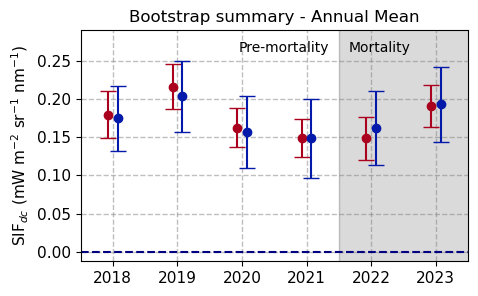

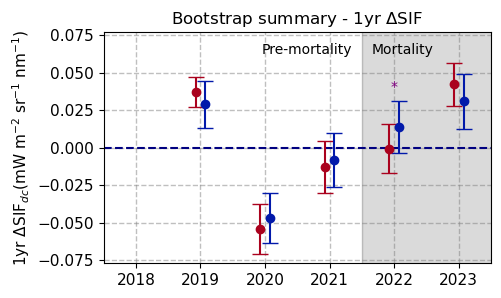

In [13]:

summary_ann_mean = functions.calculate_mean_across_dataframes(summary_ann_mean_arr)
summary_ann_mean = functions.add_significance_columns(summary_ann_mean)
summary_1yr_delta = functions.calculate_mean_across_dataframes(summary_1yr_delta_arr)
summary_1yr_delta = functions.add_significance_columns(summary_1yr_delta)

fig, ax = plt.subplots(figsize=(5, 3))
functions.plot_summary(summary_df = summary_ann_mean, 
      plot_title = r'Bootstrap summary - Annual Mean', 
      yax_label = r'SIF$_{dc}$ (mW m$^{-2}$ sr$^{-1}$ nm$^{-1}$)',
      mortality_year = estimated_mortality_year,
      fig=fig, ax=ax, plot_significance_chars=True)
plt.show()


fig, ax = plt.subplots(figsize=(5, 3))
functions.plot_summary(summary_df = summary_1yr_delta, 
      plot_title = r'Bootstrap summary - 1yr $\Delta$SIF', 
      yax_label = r'1yr $\Delta$SIF$_{dc}$' + r'(mW m$^{-2}$ sr$^{-1}$ nm$^{-1}$)',
      mortality_year = estimated_mortality_year,
      fig=fig, ax=ax, plot_significance_chars=True)

plt.show()
